# SNN-CLAPP

In [9]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from utils import  train, test
from data import load_PMNIST, load_half_MNIST, load_classwise_PMNIST, load_classwise_NMNIST, augment_nmnist
from model import CLAPP_RSNN, CLAPP_out
import numpy as np
import torch
import seaborn as sns
from scipy.signal import savgol_filter
import pickle
from main_mnist import Args


color_list = sns.color_palette()
device = 'cpu'
folder = 'models/'
model_name = folder + 'nmnist_3layer_fullCLAPP.pt'
# with open(model_name[:-3] + '_args.pkl', 'rb') as f:
#     args = pickle.load(f)
args = Args()
args.n_hidden = [512, 512, 512, 10]
dataset = 'mnist' if args.n_inputs == 28*28 else 'nmnist'

## Dataset
N-MNIST 


(34, 34, 2)


/home/lars/ownCloud/ETH/Master/Project_2/SNN_CLAPP/data.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


torch.Size([10, 1, 2312]) Target Digit: 4


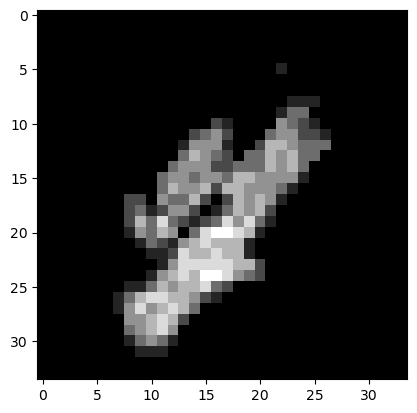

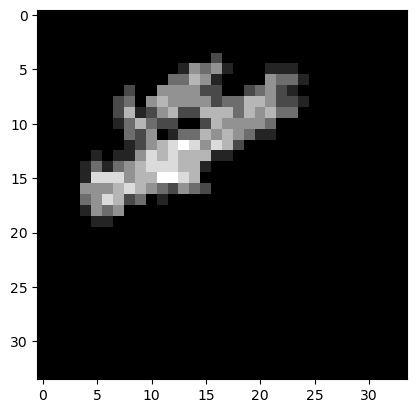

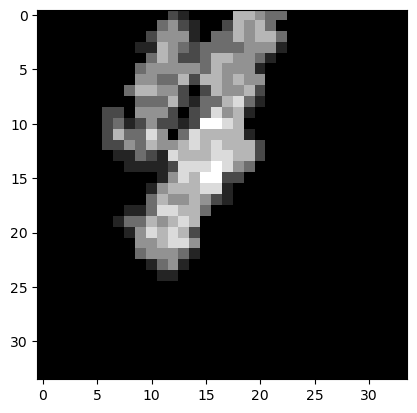

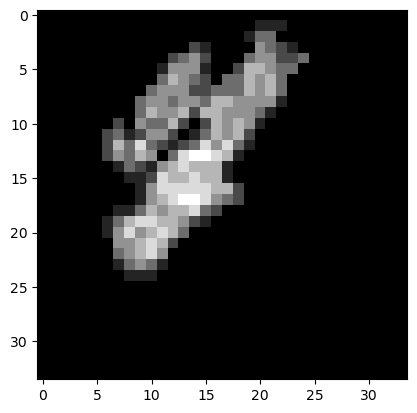

In [2]:
if dataset == 'mnist':
    train_loader, train_loader2, test_loader = load_classwise_PMNIST(args.n_time_bins, scale=args.poisson_scale, split_train=True) #load_NMNIST(n_time_bins, batch_size=batch_size)
else:
    train_loader, train_loader2, test_loader = load_classwise_NMNIST(args.n_time_bins, split_train=True)
# train_loader_full, test_loader = load_classwise_PMNIST(args.n_time_bins, scale=args.poisson_scale, split_train=False)
# Plot Example
frames, target = train_loader.next_item(-1)
print(frames.shape, f'Target Digit: {target.item()}')
plt.figure()
if dataset == 'mnist':
    plt.imshow(frames[0].view(28,28), cmap='gray')
else:
    plt.imshow(frames.squeeze().sum(axis=0).view(2,34,34)[0], cmap='gray')
for i in range(3):
    im = frames.view(10,2,34,34)
    im = augment_nmnist(im)
    plt.figure()
    plt.imshow(im.sum(axis=0)[0], cmap='gray')

## Load pretrained model

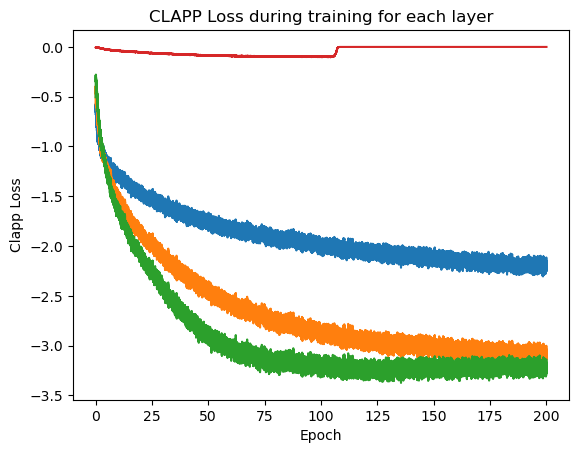

In [10]:
# SNN = CLAPP_RNN(args.n_inputs, args.n_hidden, args.n_outputs, beta=args.beta, out_proj=False).to(device)
SNN = CLAPP_RSNN(args.n_inputs, args.n_hidden, beta=args.beta, recurrency_type='none').to(device)
SNN.load_state_dict(torch.load(model_name, map_location='cpu'))
args.epochs = 200
# Load and Plot train loss history
clapp_train_losses = torch.load(f'{model_name[:-3]}_clapp_loss_hist.pt', map_location='cpu')
for i in range(clapp_train_losses.shape[1]):
    plt.plot(np.linspace(0, args.epochs, len(clapp_train_losses)), savgol_filter(clapp_train_losses[:,i], 99, 1), label=f'Layer {i+1}')
# plt.ylim([2.5, 7])
plt.ylabel('Clapp Loss')
plt.xlabel('Epoch')
plt.title('CLAPP Loss during training for each layer');
# plt.legend()

# Run clapp on the test set and get hidden states

In [11]:
clapp_activation, target_list, clapp_losses = test(SNN, test_loader, device, batch_size=args.batch_size)
print(f'Clapp loss per layer: {torch.stack(clapp_losses).mean(axis=0).numpy()}')

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

# Analyze Weights Directly

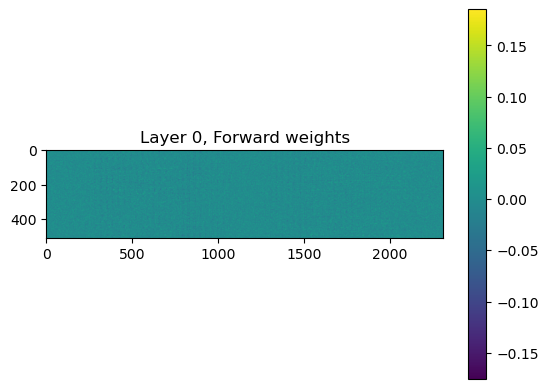

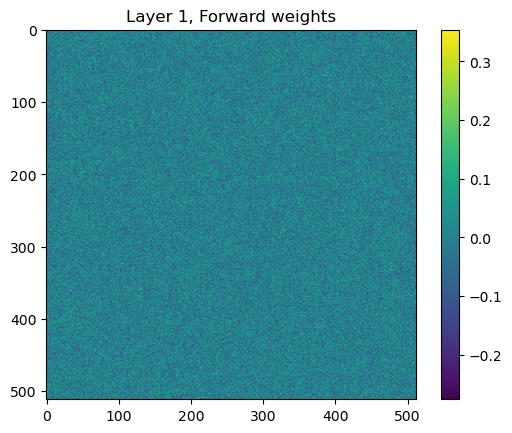

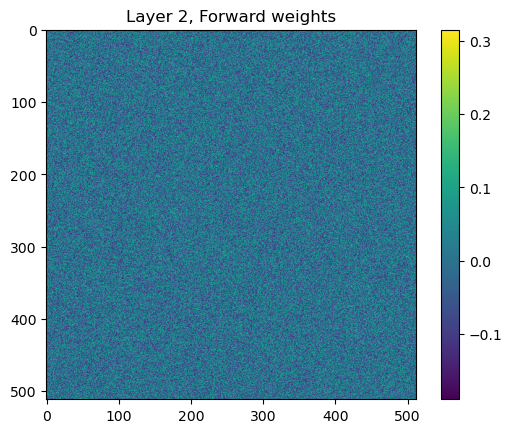

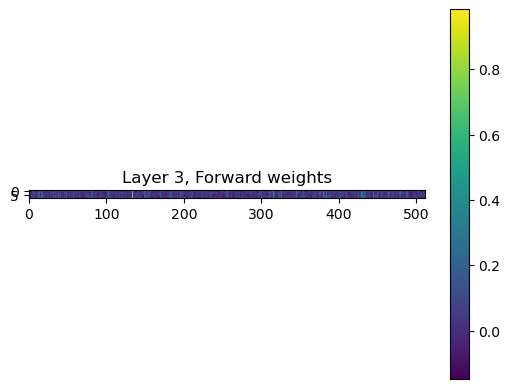

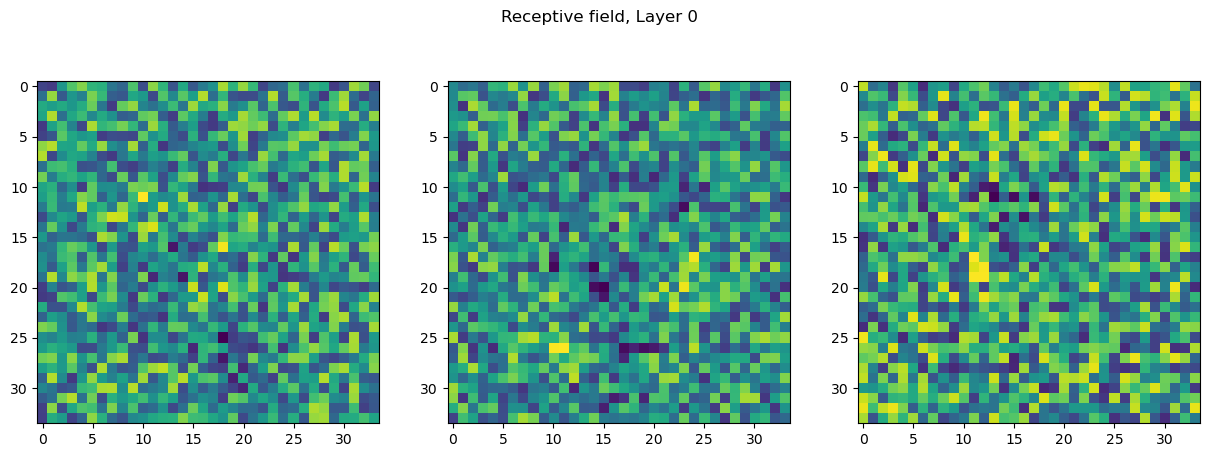

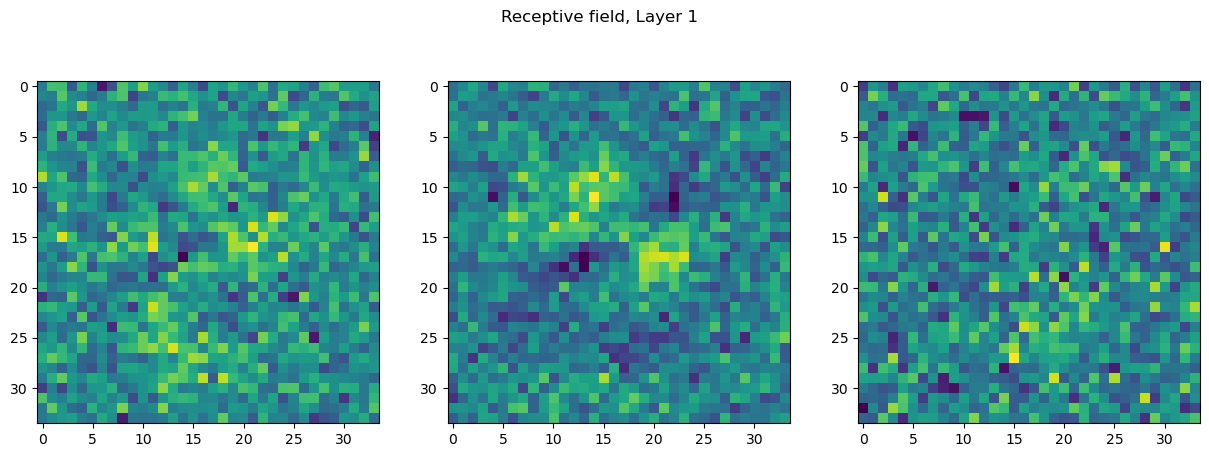

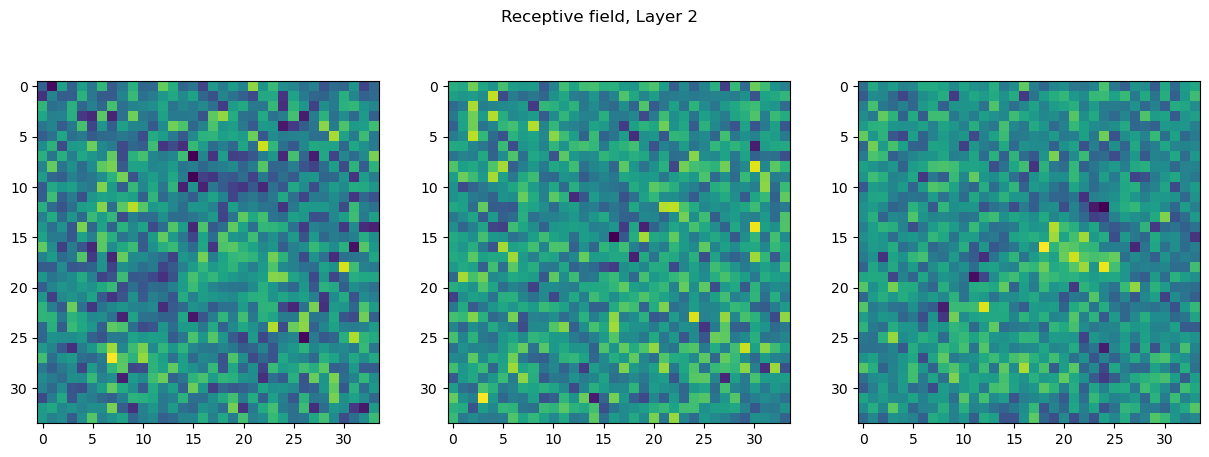

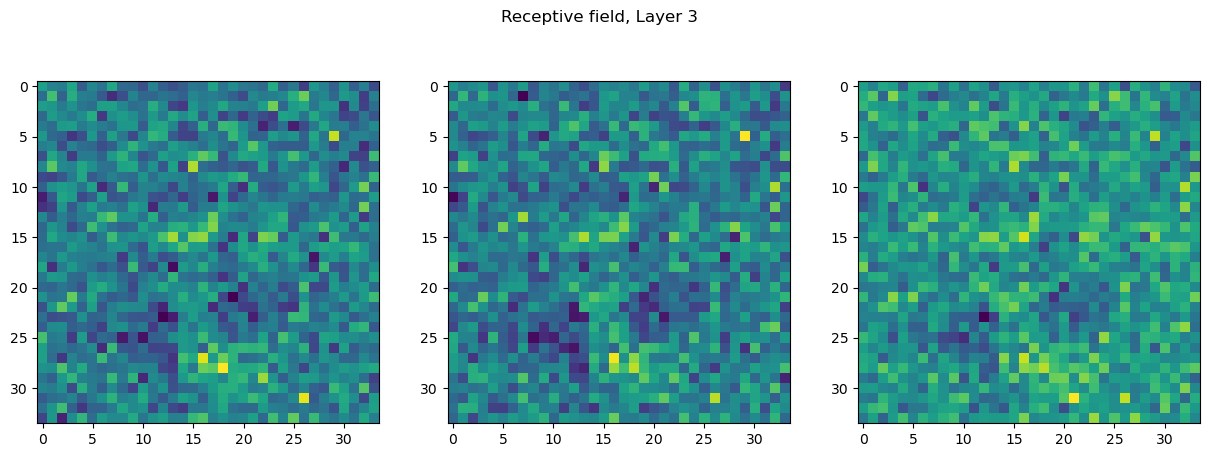

In [12]:
layers = [SNN.clapp[0].fc.weight]
for i in range(1, len(SNN.clapp)):
    layers.append(SNN.clapp[i].fc.weight @ layers[-1])

for i in range(len(SNN.clapp)):
    plt.figure()
    plt.title(f'Layer {i}, Forward weights')
    plt.imshow(SNN.clapp[i].fc.weight.detach())
    plt.colorbar()
for lidx, lay in enumerate(layers):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Receptive field, Layer {lidx}')
    for i in range(3):
        if dataset == 'mnist':
            axs[i].imshow(lay[i].view(28, 28).detach())
        else:
            axs[i].imshow(lay[i].view(2, 34, 34)[0].detach())

# Plot the projections of the hidden states

158
torch.Size([3, 10112, 512]) torch.Size([10112])
torch.Size([3, 10112, 512])
0 dead neurons
2 dead neurons
1 dead neurons


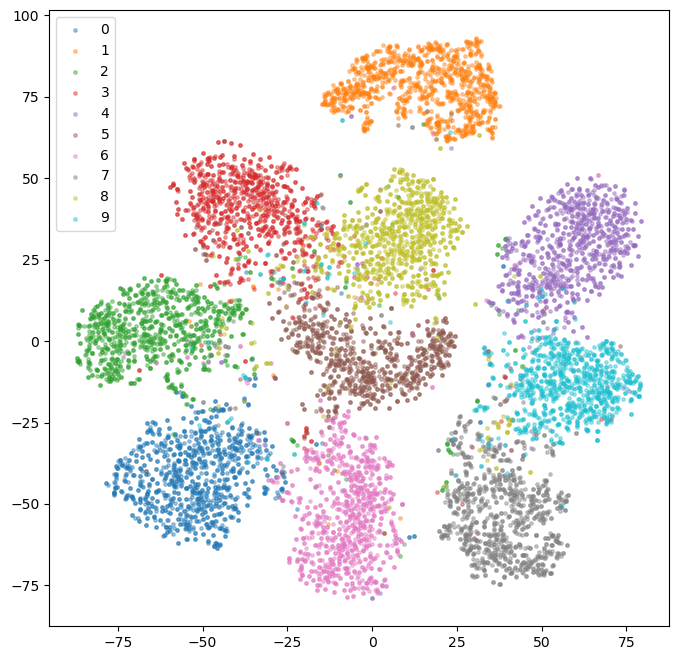

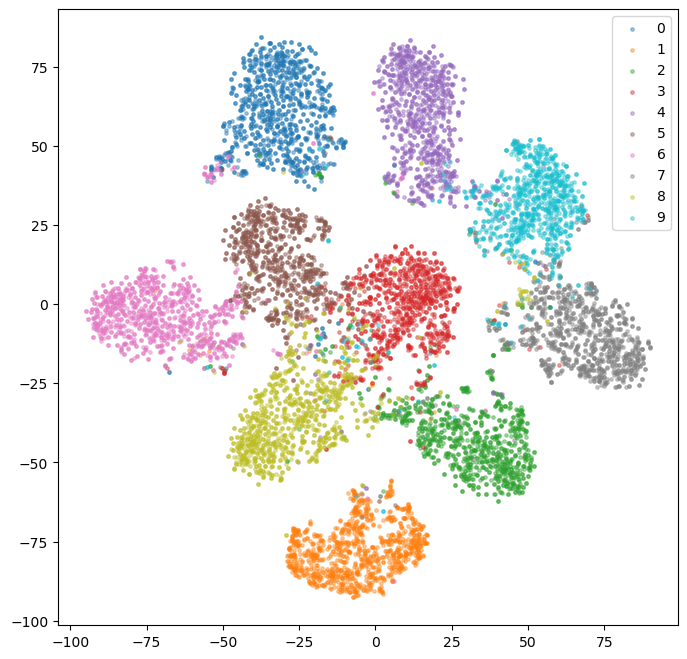

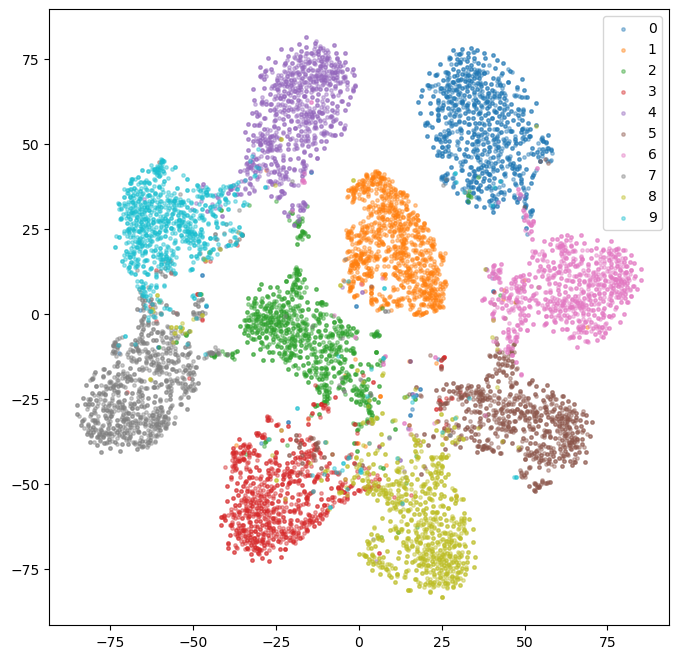

In [ ]:
print(len(clapp_activation))
hidden_activities_transformed = torch.stack(clapp_activation).swapaxes(1,2)
hidden_activities_transformed = hidden_activities_transformed.reshape(-1, hidden_activities_transformed.shape[-2], hidden_activities_transformed.shape[-1])
hidden_activities_transformed = hidden_activities_transformed.swapaxes(0,1)
target_transformed = torch.stack(target_list).flatten()
print(hidden_activities_transformed.shape, target_transformed.shape)
print(hidden_activities_transformed.shape)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
transform = TSNE()
# transform = PCA(n_components=2)
# transform = TSNE()
colors = [color_list[i.int()] for i in target_transformed]
for hat in hidden_activities_transformed:
    # Number of Neurons that never spiked during the test set
    print(f'{(hat.sum(axis=0) == 0).sum()} dead neurons')
    hat_transform = transform.fit_transform(hat.detach().cpu().numpy())
    plt.figure(figsize=(8,8))
    col = colors
    # Plot each digit separately, this makes it easier to color and label them
    for i in range(10):
        col_indeces = np.argwhere(target_transformed.squeeze() == i).squeeze()
        hattt = hat_transform[col_indeces, :]
        plt.scatter(hattt[:,0], hattt[:,1], s=6, color=color_list[i], label=i, alpha=0.4)
    plt.legend()


# Train output Projection From Each layer and from Inputs directly

In [ ]:
from model import CLAPP_out
from tqdm.notebook import tqdm
def train_out_proj(epochs, batch):
    # train output projections from all layers (and no layer)
    losses_out = []
    optimizers = []
    out_projs = []
    print_interval = 10*batch
    # SNN.out_proj.out_proj.reset_parameters()
    out_proj_0 = CLAPP_out(args.n_inputs, args.n_outputs, beta=args.beta)
    optim_0 = torch.optim.SGD(out_proj_0.parameters(), lr=1e-5)
    for lay in range(len(SNN.clapp)):
        out_projs.append(CLAPP_out(args.n_hidden[lay], args.n_outputs, beta=args.beta))
        optimizers.append(torch.optim.SGD(out_projs[-1].parameters(), lr=1e-5))
        optimizers[-1].zero_grad()
    SNN.eval()
    target = batch*[0]
    acc = []
    correct = (len(SNN.clapp) + 1)*[0]
    with torch.no_grad():
        pbar = tqdm(total=len(train_loader2)*epochs)
        while len(losses_out)*batch < len(train_loader2)*epochs:
            data, target = train_loader2.next_item(target, contrastive=True)
            SNN.reset(0)
            logit_lists = [[] for lay in range(len(SNN.clapp)+1)]
            data = data.squeeze()
            for step in range(data.shape[0]):
                data_step = data[step].float().to(device)
                target = target.to(device)
                logits, mem_his, clapp_loss = SNN(data_step, target, 0)
                logts, _ = out_proj_0(data_step, target)
                logit_lists[0].append(logts)
                for lay in range(len(SNN.clapp)):
                    logts, _ = out_projs[lay](logits[lay], target)
                    logit_lists[lay+1].append(logts)
            
            preds = [torch.stack(logit_lists[lay]).sum(axis=0) for lay in range(len(SNN.clapp)+1)]
            # if pred.max() < 1: print(pred.max())
            dL = [preds[lay].argmax(axis=-1) == target for lay in range(len(SNN.clapp)+1)]
            correct = [correct[lay] + dL[lay].sum() for lay in range(len(SNN.clapp)+1)]
            dL = [torch.zeros_like(dL[lay]) for lay in range(len(SNN.clapp) + 1)]
            out_proj_0.reset(1-dL[0].float())
            for i, out_proj in enumerate(out_projs):
                out_proj.reset(1-dL[i+1].float())

            losses_out.append(torch.tensor([torch.nn.functional.cross_entropy(preds[lay], target.squeeze().long()) for lay in range(len(SNN.clapp)+1)], requires_grad=False))

            optim_0.step()
            optim_0.zero_grad()
            for opt in optimizers:
                opt.step()
                opt.zero_grad()
            
            if len(losses_out)*batch % print_interval == 0:
                pbar.write(f'Cross Entropy Loss: {(torch.stack(losses_out)[-400//batch:].sum(dim=0)/(400//batch)).numpy()}\n' +
                           f'Correct: {100*np.array(correct)/print_interval}%')
                acc.append(np.array(correct)/print_interval)
                correct = (len(SNN.clapp) + 1)*[0]
            pbar.update(batch)
    return [out_proj_0, *out_projs], np.asarray(acc), torch.stack(losses_out)

with torch.no_grad():
    out_projs, acc, losses_out = train_out_proj(10, 2*args.batch_size)

  0%|          | 0/60000 [00:00<?, ?it/s]

Cross Entropy Loss: [3.383622  3.3132322 3.350385  3.1194103 5.486637 ]
Correct: [14.0625    2.421875  4.609375  7.1875   10.859375]%
Cross Entropy Loss: [3.0326617 3.5479386 3.2048614 3.3961134 5.361956 ]
Correct: [14.21875   8.125     7.8125   12.8125   11.328125]%
Cross Entropy Loss: [2.9624307 3.5961428 2.9017887 3.3720162 4.9774103]
Correct: [19.6875   14.765625 14.765625 27.8125   10.859375]%
Cross Entropy Loss: [2.9114282 3.0978727 2.5589788 3.4167216 4.8373666]
Correct: [19.765625 27.265625 22.578125 34.6875   12.5     ]%
Cross Entropy Loss: [2.8587677 2.850012  2.1283877 3.1119804 4.857455 ]
Correct: [21.953125 35.234375 38.203125 39.765625 11.484375]%
Cross Entropy Loss: [2.920348  2.559741  2.0182583 2.7252922 4.882318 ]
Correct: [20.078125 38.828125 46.953125 41.09375  10.46875 ]%
Cross Entropy Loss: [2.8807495 2.2941225 1.7860712 2.6985416 4.541468 ]
Correct: [18.359375 42.578125 56.25     41.171875 10.3125  ]%
Cross Entropy Loss: [2.9194553 2.1881864 1.7000575 2.43343   4

Accuracy of last quarter: [12.65625    89.85026042 92.40885417 92.33072917 10.859375  ]%


IndexError: list index out of range

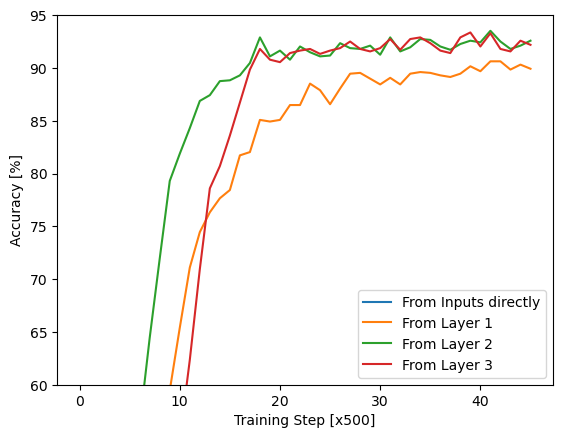

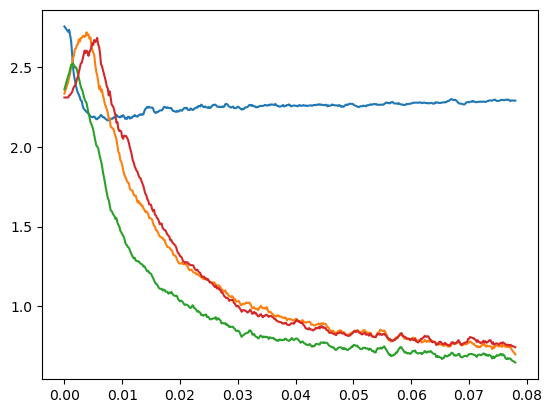

In [ ]:
print(f'Accuracy of last quarter: {100*acc[-len(acc)//4:].mean(axis=0)}%')
plt.figure()
plt.plot(np.asarray(acc)*100)
plt.ylabel('Accuracy [%]')
plt.xlabel('Training Step [x500]')
labels = ['From Inputs directly', 'From Layer 1', 'From Layer 2', 'From Layer 3']
plt.legend(labels)
plt.ylim([60, 95])
plt.figure()
for i in range(losses_out.shape[1]):
    plt.plot(np.arange(len(losses_out))/len(train_loader2), savgol_filter(losses_out[:,i], 9, 1), label=labels[i])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Training Step')
plt.ylim([0, 1.5])
plt.legend(['From Inputs directly', 'From Layer 1', 'From Layer 2', 'From Layer 3']);

## Test Accuracy on Test Set

  0%|          | 0/157 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 9.17%
From layer 1:
Accuracy: 90.31%
From layer 2:
Accuracy: 92.67%
From layer 3:
Accuracy: 92.44%
From layer 4:
Accuracy: 8.59%


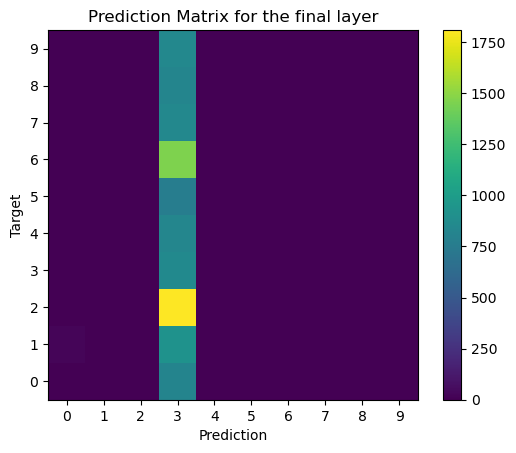

In [ ]:
correct = torch.zeros(len(out_projs))
for out_proj in out_projs:
    out_proj.eval()
SNN.eval()
pred_matrix = torch.zeros(args.n_outputs, args.n_outputs)
for idx in trange(0, len(test_loader), args.batch_size):
    for out_proj in out_projs:
        out_proj.reset()
    SNN.reset(0)
    if dataset == 'mnist':
        inp, target = test_loader.x[idx:idx+args.batch_size], test_loader.y[idx:idx+args.batch_size]
    else:
        until = min(args.batch_size, len(test_loader.data) - idx)
        inp = torch.stack([torch.tensor(test_loader.data[idx+i][0]).view(args.n_time_bins, -1) for i in range(until)])
        target = torch.tensor([test_loader.data[idx+i][1] for i in range(until)])
    logits = len(out_projs)*[torch.zeros((inp.shape[0],args.n_outputs))]
    for step in range(inp.shape[1]):
        data_step = inp[:,step].float().to(device)
        spk_step, _, _ = SNN(data_step, None, 0)
        spk_step = [data_step, *spk_step]
        for i, out_proj in enumerate(out_projs):
            out, _ = out_proj(spk_step[i], target)
            logits[i] = logits[i] + out
    for i, logit in enumerate(logits):
        pred = logit.argmax(axis=-1)
        correct[i] += int((pred == target).sum())
    # for the last layer create the prediction matrix
    for j in range(pred.shape[0]):
        pred_matrix[int(target[j]), int(pred[j])] += 1
correct /= len(test_loader)
print('Directly from inputs:')
print(f'Accuracy: {100*correct[0]:.2f}%')
for i in range(len(out_projs)-1):
    print(f'From layer {i+1}:')
    print(f'Accuracy: {100*correct[i+1]:.2f}%')

plt.imshow(pred_matrix, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(args.n_outputs)])
plt.yticks([i for i in range(args.n_outputs)])
plt.colorbar();

# Few-Shot

  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 90.29%
From layer 2:
Accuracy: 92.97%
From layer 3:
Accuracy: 93.76%
From layer 4:
Accuracy: 8.18%
Accuracy per Layer: tensor([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])%


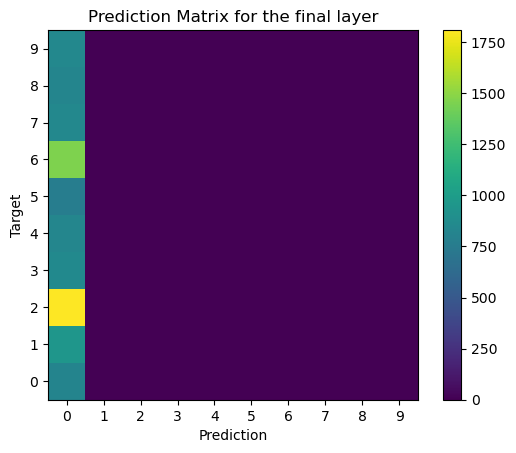

In [ ]:
# Randomly select one sample of each class and save the spiking activity
SNN.reset(0)
one_shot_samples = torch.zeros(args.n_outputs, args.n_time_bins, args.n_inputs)
one_shot_spks = [torch.zeros(args.n_outputs, h) for h  in args.n_hidden]
k = 50
for i in range(args.n_outputs):
    for j in range(k):
        img, _ = train_loader2.next_item(i, contrastive=False)
        one_shot_samples[i] = img.squeeze()
        for t in range(args.n_time_bins):
            logits, mem_his, clapp_loss = SNN(img[t].float(), 0, 0)
            for idx, log in enumerate(logits):
                one_shot_spks[idx][i] += log.squeeze()

# oneshotmax = one_shot_spks[-1].argmax(axis=1)
# print(oneshotmax)
# one_shot_spks[-1] = torch.zeros(10,10)
# for i in range(10):
#     one_shot_spks[-1][i,oneshotmax[i]] = 1

def metric(spk, one_shot):
    dists = torch.zeros(spk.shape[0], args.n_outputs)
    for i in range(args.n_outputs):
        one_shot_i = one_shot[i] - one_shot[i].mean(axis=0)
        dists[:, i] = torch.einsum('bi, i->b' , spk, one_shot_i)
    return dists

def get_predictions(spks):
    preds = torch.zeros(len(spks), spks[0].shape[0])
    # for each layer get the prediction
    for i in range(len(spks)):
        dists = metric(spks[i], one_shot_spks[i])
        preds[i] = dists.argmax(axis=-1)
    return preds

batch = int(len(test_loader)/10)
correct_oneshot = torch.zeros(len(SNN.clapp))
SNN.eval()
pred_matrix_oneshot = torch.zeros(args.n_outputs, args.n_outputs)
for idx in trange(0, len(test_loader), batch):
    SNN.reset(0)
    if dataset == 'mnist':
        inp, target = test_loader.x[idx:idx+batch], test_loader.y[idx:idx+batch]
    else:
        until = min(batch, len(test_loader.data) - idx)
        inp = torch.stack([torch.tensor(test_loader.data[idx+i][0]).view(args.n_time_bins, -1) for i in range(until)])
        target = torch.tensor([test_loader.data[idx+i][1] for i in range(until)])
    logits = [torch.zeros(inp.shape[0], h) for h  in args.n_hidden]
    for step in range(inp.shape[1]):
        data_step = inp[:,step].float().to(device)
        spk_step, _, _ = SNN(data_step, None, 0)
        for logidx in range(len(spk_step)):
            logits[logidx] += spk_step[logidx]
    preds = get_predictions(logits)
    for i in range(preds.shape[0]):
        correct_oneshot[i] += int((preds[i] == target).sum())
    # for the last layer create the prediction matrix
    for j in range(preds.shape[1]):
        pred_matrix_oneshot[int(target[j]), int(preds[-1, j])] += 1
correct_oneshot /= len(test_loader)
for i in range(len(SNN.clapp)):
    print(f'From layer {i+1}:')
    print(f'Accuracy: {100*correct_oneshot[i]:.2f}%')

plt.imshow(pred_matrix_oneshot, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(args.n_outputs)])
plt.yticks([i for i in range(args.n_outputs)])
plt.colorbar();
print(f'Accuracy per Layer: {100*pred_matrix_oneshot.diag()/pred_matrix_oneshot.sum(axis=1)}%') # correct axis?

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor([4, 8, 5, 3, 5, 3, 0, 7, 0, 5])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0